In [30]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

import torch
from torch.nn import MSELoss
from torcheval.metrics import R2Score
from torch.utils.data import DataLoader
from torchvision import transforms

from transformers import AdamW, get_scheduler

from jre_utils.datapath import model_ready_data_paths
from jre_utils.data import JapanRETimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel
from jre_utils.metrics import MSELossWeighted

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [10]:
metrics = {
    "weighted_mean": "unit_price_wmean",
    "weighted_median": "unit_price_wmedian",
    "mean": "unit_price_mean",
    "median": "unit_price_median",
}

metric = metrics["weighted_median"]
metric_pct_chg = metric + "_pct_chg"
normalized_metric_pct_chg = "normalized_" + metric + "_pct_chg"

In [11]:
start_year = 2006
eval_start_year = 2021 # eval_years = [2021]

dataset_key = "transactions"
model_ready_data_path = model_ready_data_paths[f"sequence_{dataset_key}"]

df = pd.read_csv(model_ready_data_path)

df[normalized_metric_pct_chg] = df.groupby("year")[
    metric_pct_chg
].transform(lambda x: (x - x.mean()) / x.std())

train_df = df[(df["year"] >= start_year) & (df["year"] < eval_start_year)]
eval_df = df[df["year"] >= eval_start_year]

In [12]:
df.columns

Index(['unit_price_wmedian_pct_chg', 'unit_price_wmedian', 'year', 'count',
       'total_traded_area', 'population', 'taxpayer_count', 'taxable_income',
       'taxable_income_per_taxpayer', 'taxable_income_growth',
       'taxable_income_per_taxpayer_growth', 'new_dwellings',
       'existing_dwellings', 'net_migration_ratio', 'new_dwellings_ratio',
       'area_code', 'normalized_unit_price_wmedian_pct_chg'],
      dtype='object')

In [13]:
columns = [
    metric,
    metric_pct_chg,
    "count",
    "total_traded_area",
    "population",
    "taxpayer_count",
    "taxable_income",
    "taxable_income_per_taxpayer",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "new_dwellings",
    "existing_dwellings",
    "new_dwellings_ratio",
    "net_migration_ratio",
]
columns_normalized = [f"{col}_normalized" for col in columns]

train_df_mean = train_df[columns].mean()
train_df_std = train_df[columns].std()
train_df[columns_normalized] = (train_df[columns] - train_df_mean) / train_df_std
eval_df[columns_normalized] = (eval_df[columns] - train_df_mean) / train_df_std

count_scale_factor = 3
count_max = train_df["count"].max()
train_df["count_scaled"] = 1 + (train_df["count"] / count_max) * 3
eval_df["count_scaled"] = 1 + (eval_df["count"] / count_max) * 3

df = pd.concat([train_df, eval_df])

# more detailed area level normalization would help

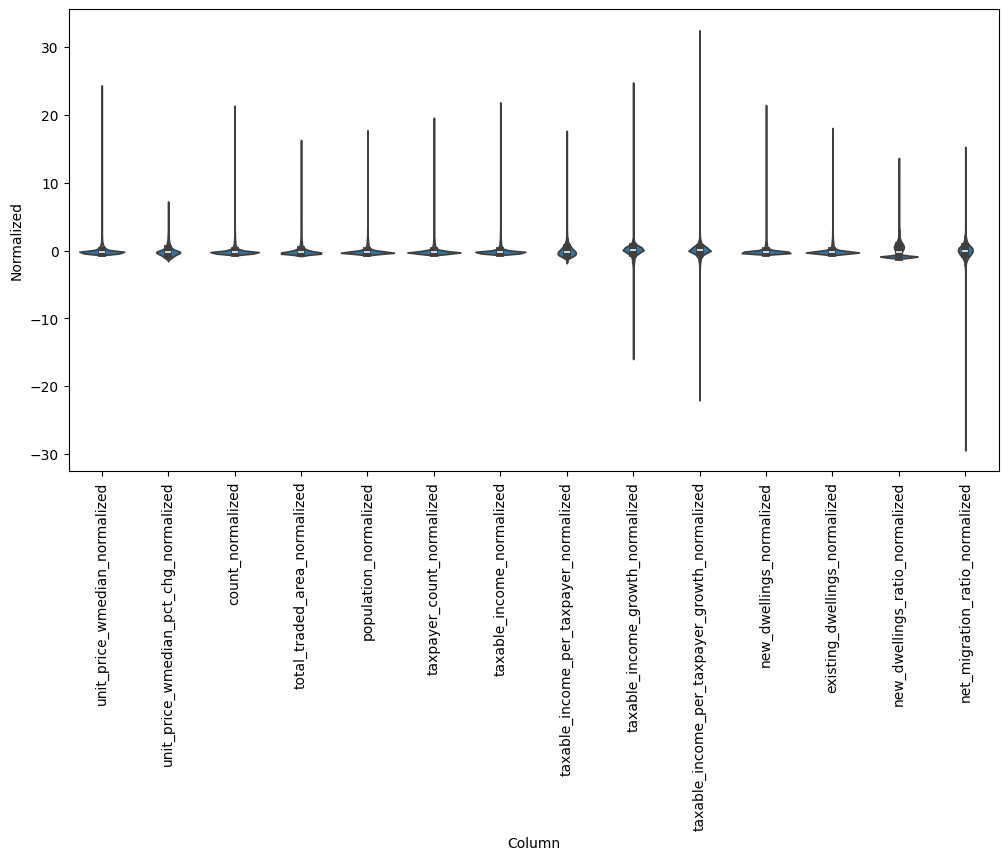

In [14]:
df_std = df[columns_normalized].melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df[columns_normalized].keys(), rotation=90)

In [15]:
# Will yearly normalized columns be better?
# If average net migration higher for factor area X over area Y in the same year, I would think it would have higher return
# Compared to normalizing over all years. That also gives us access to future years which is undesirable

columns_normalized_yearly = [f"{col}_normalized_yearly" for col in columns]
for col in columns:
    df[f"{col}_normalized_yearly"] = df.groupby("year")[col].transform(
        lambda x: (x - x.mean()) / x.std()
    )

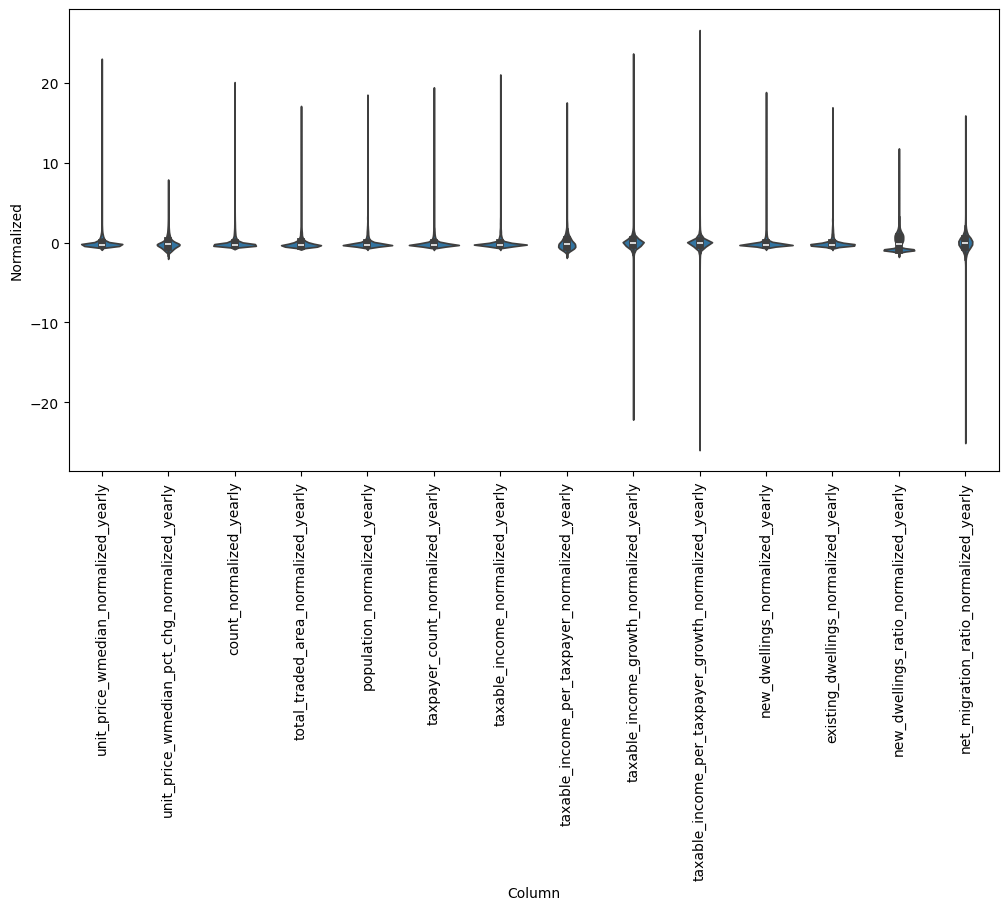

In [16]:
df_std = df[columns_normalized_yearly].melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df[columns_normalized_yearly].keys(), rotation=90)

In [17]:
feature_columns = [metric_pct_chg] + columns_normalized_yearly

time_series_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    feature_columns=feature_columns,
)

time_series_dataset_transformed = JapanRETimeSeriesDataset(
    df,
    train_df,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)

for i, sample in enumerate(time_series_dataset):
    print(
        i,
        sample["window"].shape,
        sample["target"].shape,
        sample["target"].values,
        sample["weight"].values,
    )
    if i == 3:
        break


for i, sample in enumerate(time_series_dataset_transformed):
    print(
        i,
        sample["window"].shape,
        sample["target"].shape,
        sample["target"],
        sample["weight"],
    )
    if i == 3:
        break

0 (0, 15) (1,) [-0.11753499] [2.27351996]
1 (1, 15) (1,) [-0.06463789] [2.27489674]
2 (2, 15) (1,) [-0.24996912] [2.27489674]
3 (3, 15) (1,) [-0.2744253] [2.41945847]
0 torch.Size([5, 32]) torch.Size([1]) tensor([-0.1175]) tensor([2.2735])
1 torch.Size([5, 32]) torch.Size([1]) tensor([-0.0646]) tensor([2.2749])
2 torch.Size([5, 32]) torch.Size([1]) tensor([-0.2500]) tensor([2.2749])
3 torch.Size([5, 32]) torch.Size([1]) tensor([-0.2744]) tensor([2.4195])


In [18]:
BATCH_SIZE = 128

In [19]:
train_dataset = JapanRETimeSeriesDataset(
    df,
    train_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)
eval_dataset = JapanRETimeSeriesDataset(
    df,
    eval_df,
    feature_columns=feature_columns,
    metrics=[normalized_metric_pct_chg],
    weight_column="count_scaled",
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

eval_dataloader = DataLoader(
    eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

### Building the Transformer Model

In [20]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [21]:
n_features = len(feature_columns)
d_model = 128
d_hid = 256
nlayers = 4
nhead = 4
dropout = 0
enc_dropout = 0

model = TimeSeriesTransformerModel(
    n_features=n_features,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout,
    enc_dropout=enc_dropout,
    device=device,
)
model = model.to(device)


In [33]:
model.eval()

with torch.no_grad():
    for batch in eval_dataloader:
        window = batch["window"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        weight = batch["weight"].to(device)

        outputs = model(window, mask)
        loss = mse_loss_weighted(outputs, target, weight)

        print(
            batch["window"].shape,
            batch["mask"].shape,
            batch["target"].shape,
            batch["weight"].shape,
        )

        print(outputs.shape)
        
        print("Loss:", loss.item())

        break

torch.Size([128, 5, 15]) torch.Size([128, 5]) torch.Size([128, 1]) torch.Size([128, 1])
torch.Size([128, 1])
Loss: 1.714808464050293


In [32]:
def extract_transformer_encoder_state_dict(state_dict):
    transformer_state_dict = {}
    for key, value in state_dict.items():
        if "transformer_encoder" in key:
            transformer_state_dict[key] = value
    return transformer_state_dict

loaded_state_dict = extract_transformer_encoder_state_dict(torch.load("../../weights/jena_climate.pt"))
model.load_state_dict(loaded_state_dict, strict=False)

# Write a pretraining loop to go over all datasets and pretrain on that
# Use early stopping so you don't have to worry about overfitting
# Write the required parameters and processing functions for all the datasets and put them all in a dictionary


_IncompatibleKeys(missing_keys=['embedding.weight', 'embedding.bias', 'pos_encoder.pe', 'linear.weight', 'linear.bias'], unexpected_keys=[])

In [23]:
learning_rate = 1e-4 # 3e-4
num_epochs = 10

In [24]:
# mse_loss = MSELoss().to(device)
mse_loss_weighted = MSELossWeighted().to(device)

num_training_steps = num_epochs * len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=learning_rate)

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

def train(model, progress_bar):
    model.train()
    
    running_loss = 0.0
    r2_score = R2Score(device=device)

    for batch in train_dataloader:
        window = batch["window"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        weight = batch["weight"].to(device)

        outputs = model(window, mask)
        loss = mse_loss_weighted(outputs, target, weight)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        running_loss += loss.item() * len(batch)
        r2_score.update(outputs, target)
        progress_bar.update(1)

    return running_loss / len(train_dataloader), r2_score.compute().item()
    
def evaluate(model):
    model.eval()
    
    running_loss = 0.0
    r2_score = R2Score(device=device)

    with torch.no_grad():
        for batch in eval_dataloader:
            window = batch["window"].to(device)
            mask = batch["mask"].to(device)
            target = batch["target"].to(device)
            weight = batch["weight"].to(device)

            outputs = model(window, mask)
            loss = mse_loss_weighted(outputs, target, weight)

            running_loss += loss.item() * len(batch)
            r2_score.update(outputs, target)

    return running_loss / len(eval_dataloader), r2_score.compute().item()

In [36]:
train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

In [37]:
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    train_loss, train_r2_score = train(model, progress_bar)
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)

    eval_loss, eval_r2_score = evaluate(model)
    eval_losses.append(eval_loss)
    eval_r2_scores.append(eval_r2_score)

progress_bar.close()

  0%|          | 0/1440 [00:00<?, ?it/s]

100%|██████████| 1440/1440 [04:33<00:00,  5.27it/s]


In [721]:
# model has too many parameters, as such, it has too many ways to fit to the same data

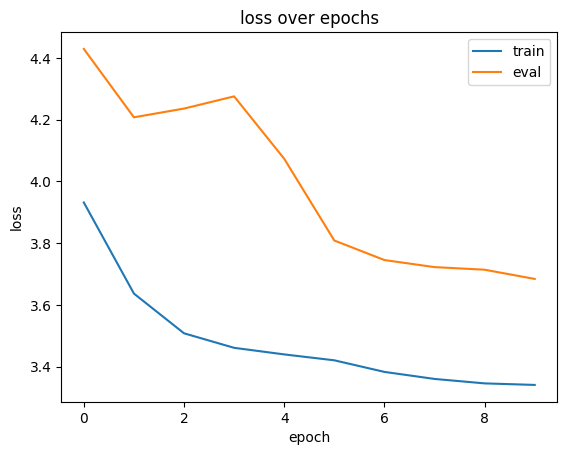

In [38]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

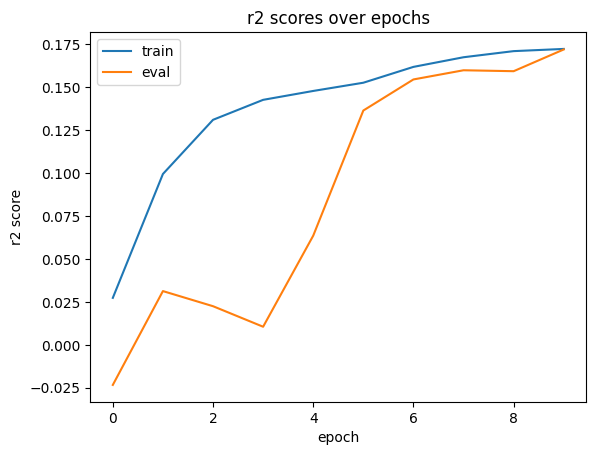

In [39]:
# Plot R2 scores
plt.plot(train_r2_scores, label = "train")
plt.plot(eval_r2_scores, label = "eval")
plt.xlabel('epoch')
plt.ylabel('r2 score')
plt.title('r2 scores over epochs')
plt.legend()
plt.show()

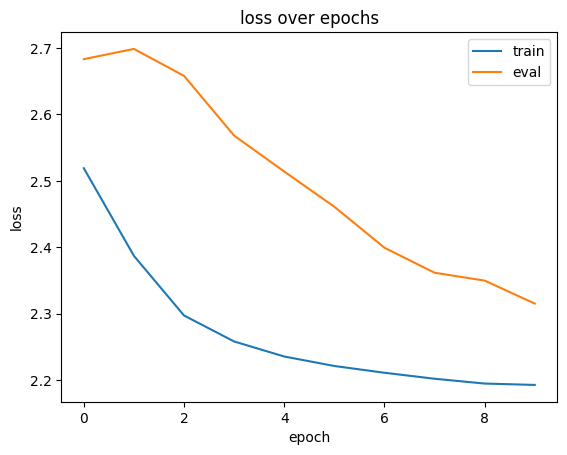

In [703]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

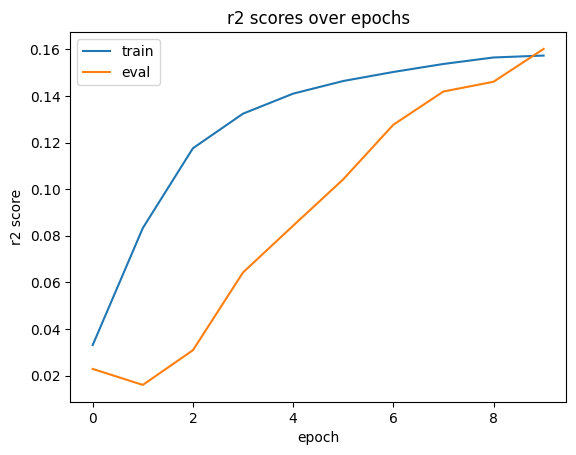

In [704]:
# Plot R2 scores
plt.plot(train_r2_scores, label = "train")
plt.plot(eval_r2_scores, label = "eval")
plt.xlabel('epoch')
plt.ylabel('r2 score')
plt.title('r2 scores over epochs')
plt.legend()
plt.show()

In [40]:
# untrained model
loss, epoch_r2_score = evaluate(model)
print(f"Eval loss: {loss:.4f}")
print(f"Eval R2: {epoch_r2_score:.4f}")

Eval loss: 3.6842
Eval R2: 0.1720


### Pretraining and transfer gameplan

Within my time series model, I have the Transformer Encoder and the Positional Encoder. 
Once the model is done training, I will take the weights and save it to a file.
Then, I will load up the new model with this file.



In [ ]:
# mse_loss = MSELoss()

# progress_bar = tqdm(range(num_training_steps))

# train_losses, train_r2_scores, eval_losses, eval_r2_scores = [], [], [], []

# phases = ["train", "eval"]

# for epoch in range(num_epochs):
#     for phase in phases:
#         running_loss = 0.0
#         r2_score = R2Score(device=device)

#         if phase == "train":
#             model.train()
#             dataloader, losses, r2_scores = train_dataloader, train_losses, train_r2_scores
#         else:
#             model.eval()
#             dataloader, losses, r2_scores = eval_dataloader, eval_losses, eval_r2_scores

#         for batch in dataloader:
#             window = batch["window"].to(torch.float32).to(device)
#             mask = batch["mask"].to(torch.float32).to(device)
#             target = batch["target"].to(torch.float32).to(device)

#             outputs = model(window, mask)
#             loss = mse_loss(outputs, target)

#             if phase == "train":
#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()
#                 lr_scheduler.step()
#                 progress_bar.update(1)

#             running_loss += loss.item() * len(batch)
#             r2_score.update(outputs, target)

#         losses.append(running_loss / len(dataloader))
#         r2_scores.append(r2_score.compute().item())

# progress_bar.close()

In [103]:
test_year = 2021

presentation_df = df[df["area_code"].astype(int) // 1000 == 13]
presentation_df = presentation_df[presentation_df["year"] == test_year]
presentation_dataset = TimeSeriesDataset(
    df,
    presentation_df,
    feature_columns=feature_columns,
    transform=transforms.Compose([ToNumpy(), PadAndMask(), ToTensor()]),
)
presentation_dataloader = None

In [106]:
next(iter(presentation_dataloader))['window'].shape

torch.Size([49, 5, 14])

In [109]:
tokyo_dataset = next(iter(presentation_dataloader))
model.eval()
tokyo_output = model(tokyo_dataset['window'].to(torch.float32).to(device), tokyo_dataset['mask'].to(torch.float32).to(device))

In [110]:
tokyo_output

tensor([[ 0.0130],
        [-0.0186],
        [ 0.0277],
        [ 0.0216],
        [ 0.0877],
        [ 0.0506],
        [ 0.0254],
        [ 0.0862],
        [-0.0248],
        [-0.0092],
        [-0.1615],
        [-0.0008],
        [-0.2429],
        [-0.0291],
        [-0.0184],
        [-0.0267],
        [ 0.0206],
        [ 0.0577],
        [ 0.0117],
        [ 0.0127],
        [ 0.0254],
        [ 0.0156],
        [ 0.0252],
        [-0.0175],
        [ 0.0059],
        [-0.0571],
        [ 0.0357],
        [-0.0107],
        [-0.0207],
        [ 0.0368],
        [ 0.0526],
        [ 0.0167],
        [-0.1445],
        [ 0.0624],
        [ 0.0102],
        [-0.0105],
        [-0.0181],
        [-0.0953],
        [ 0.0091],
        [ 0.0136],
        [ 0.0164],
        [ 0.0693],
        [ 0.0277],
        [-0.0114],
        [ 0.0668],
        [ 0.0488],
        [ 0.0630],
        [-0.0585],
        [ 0.0442]], device='mps:0', grad_fn=<LinearBackward0>)

### Important Questions:
1. What is the optimal error?
2. What is the human level error?
3. How much better or worse is the model compared to human level error?

My assumption is that optimal error is zero %, and human level error is close to that. 
But it is likely that the human level error is considerably worse.

#### The High Bias Problem (Fixed):

Right now, it seems to be that the model is facing a problem with high bias. The loss mins out at around 0.4
This is a problem, because the reason I built this model was because I thought it could outperform the XGBoost model.
But as it stands, the XGboost brings down loss to as low as 0.05.
Now, it is overfitting considerably with Train R2 being 0.3979 and Test R2 being 0.2376
But it is pretty surprising that the model is not able to fit harder.

The solutions suggested by Andrew Ng are:
1. Bigger Network (Increase number of hidden units, attention heads, and layers)
2. Train for longer (more number of epoch)
   1. I'm doing this, but weirdly enough, it ends up just slowing the model instead of progressing this further
3. Use a different architechture
   1. Maybe I'm being stubborn, but the advent of transformer models have changed machine learning permanently. So I would like to continue the use of this architecture

### The High Variance Problem

The model is overfitting right now

In [ ]:

# How do I make the model better?
# Model is currently underfitting. Make it overfit first.

# Basic
# Hyperparameter Tuning
#   1. Learning rate.
#   2. No. of hidden units.
#   3. No. of layers.
# Alternative Cost Function
#   1. Weighted MSE loss - Weighted on count

# Advanced
# Pretrain on the Time Series Datasets
